##### Imports & Constants

In [11]:
import pathlib
import pandas as pd

import sklearn.model_selection as ms
import sklearn.linear_model as lm
import sklearn.ensemble as ske
import sklearn.metrics as skm

FINAL_DATA_PATH = pathlib.Path('..') / 'data' / 'final' / 'final_data.csv'
PCA_DATA_PATH = pathlib.Path('..') / 'data' / 'final' / 'pca_data.csv'

final_data = pd.read_csv(FINAL_DATA_PATH)
pca_data = pd.read_csv(PCA_DATA_PATH)

X, y = final_data.drop('position', axis=1), final_data['position']
pca_X, pca_y = pca_data, final_data['position']

# Split data into train and test sets
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
pca_X_train, pca_X_test, pca_y_train, pca_y_test = ms.train_test_split(pca_X, pca_y, test_size=0.2, random_state=42, shuffle=True)

##### Inital Model

In [12]:
rf = ske.RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Metrics
print(skm.accuracy_score(y_test, y_pred))
print(skm.f1_score(y_test, y_pred, average='weighted'))


0.8399540437976535
0.8356406185373227


<AxesSubplot: >

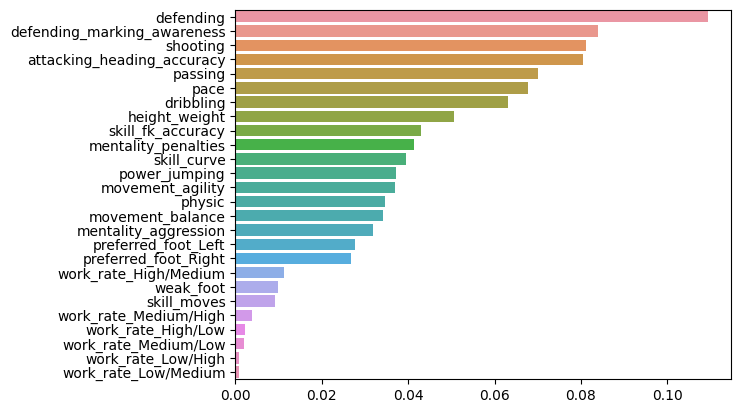

In [13]:
# draw the feature importance graph
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index)

##### Inital Model (PCA)

In [14]:
rf = ske.RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(pca_X_train, pca_y_train)
y_pred = rf.predict(pca_X_test)

# Metrics
print(skm.accuracy_score(pca_y_test, y_pred))
print(skm.f1_score(pca_y_test, y_pred, average='weighted'))


0.7797583817846325
0.773410072358607


In [16]:
lr = lm.LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Metrics
print(skm.accuracy_score(y_test, y_pred))
print(skm.f1_score(y_test, y_pred, average='weighted'))

0.7576506632315566
0.7451892723077622
